In [1]:
# autoreload nangs
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#imports
import math
import numpy as np 
import matplotlib.pyplot as plt 
import torch

In [3]:
from nangs.pde import PDE
from nangs.bocos import PeriodicBoco, DirichletBoco, NeumannBoco
from nangs.solutions import MLP

class MyPDE(PDE):
    def __init__(self, inputs=None, outputs=None, order=2):
        super().__init__(inputs, outputs, order=order)
    def computePDELoss(self, grads, inputs, outputs, params): 
        dpdt = grads['p']['t']
        d2pdx2, d2pdy2, d2pdz2 = grads['2p']['xx'], grads['2p']['yy'], grads['2p']['zz']
        return [dpdt - (d2pdx2 + d2pdy2 + d2pdz2)]

# instanciate pde
pde = MyPDE(inputs=['x', 'y', 'z', 't'], outputs=['p'])

# define input values
x = np.linspace(0,1,10)
y = np.linspace(0,1,10)
z = np.linspace(0,1,10)
t = np.linspace(0,5,10)

pde.setValues({'x': x, 'y': y, 'z': z, 't': t})

In [4]:
# initial condition (dirichlet for temporal dimension)
p0 = np.zeros(len(y[1:-1])*len(x[1:-1])*len(z[1:-1]))       
boco = DirichletBoco('initial_condition', {'x': x[1:-1], 'y': y[1:-1], 'z': z[1:-1], 't': np.array([0])}, {'p': p0})
pde.addBoco(boco)

px0 = np.zeros(len(x))
boco = DirichletBoco('initial_conditionEdgeXSouthBottom', {'x': x, 'y': y[:1], 'z': z[:1], 't': np.array([0])}, {'p': px0})
pde.addBoco(boco)
boco = DirichletBoco('initial_conditionEdgeXNorthBottom', {'x': x, 'y': y[-1:], 'z': z[:1], 't': np.array([0])}, {'p': px0})
pde.addBoco(boco)
boco = DirichletBoco('initial_conditionEdgeXSouthTop', {'x': x, 'y': y[:1], 'z': z[-1:], 't': np.array([0])}, {'p': px0})
pde.addBoco(boco)
boco = DirichletBoco('initial_conditionEdgeXNorthTop', {'x': x, 'y': y[-1:], 'z': z[-1:], 't': np.array([0])}, {'p': px0})
pde.addBoco(boco)

py0 = np.zeros(len(y))
boco = DirichletBoco('initial_conditionEdgeYLeftBottom', {'x': x[:1], 'y': y, 'z': z[:1], 't': np.array([0])}, {'p': py0})
pde.addBoco(boco)
boco = DirichletBoco('initial_conditionEdgeYRightBottom', {'x': x[-1:], 'y': y, 'z': z[:1], 't': np.array([0])}, {'p': py0})
pde.addBoco(boco)
boco = DirichletBoco('initial_conditionEdgeYLeftTop', {'x': x[:1], 'y': y, 'z': z[-1:], 't': np.array([0])}, {'p': py0})
pde.addBoco(boco)
boco = DirichletBoco('initial_conditionEdgeYRightTop', {'x': x[-1:], 'y': y, 'z': z[-1:], 't': np.array([0])}, {'p': py0})
pde.addBoco(boco)

pz0 = np.zeros(len(z))
boco = DirichletBoco('initial_conditionEdgeZSouthLeft', {'x': x[:1], 'y': y[:1], 'z': z, 't': np.array([0])}, {'p': pz0})
pde.addBoco(boco)
boco = DirichletBoco('initial_conditionEdgeZSouthRight', {'x': x[-1:], 'y': y[:1], 'z': z, 't': np.array([0])}, {'p': pz0})
pde.addBoco(boco)
boco = DirichletBoco('initial_conditionEdgeZLeftNorth', {'x': x[:1], 'y': y[-1:], 'z': z, 't': np.array([0])}, {'p': pz0})
pde.addBoco(boco)
boco = DirichletBoco('initial_conditionEdgeZRightNorth', {'x': x[-1:], 'y': y[-1:], 'z': z, 't': np.array([0])}, {'p': pz0})
pde.addBoco(boco)

boco = DirichletBoco('south', {'x': x[1:-1], 'y': y[:1], 'z': z[1:-1], 't': t}, {'p': np.zeros(len(x[1:-1])*len(z[1:-1])*len(t))})
pde.addBoco(boco)

boco = DirichletBoco('north', {'x': x[1:-1], 'y': y[-1:], 'z': z[1:-1], 't': t}, {'p': np.zeros(len(x[1:-1])*len(z[1:-1])*len(t))})
pde.addBoco(boco)

boco = DirichletBoco('left', {'x': x[:1], 'y': y[1:-1], 'z': z[1:-1], 't': t}, {'p': np.full(len(y[1:-1])*len(z[1:-1])*len(t), 1.0)})
pde.addBoco(boco)

boco = DirichletBoco('right', {'x': x[-1:], 'y': y[1:-1], 'z': z[1:-1], 't': t}, {'p': np.full(len(y[1:-1])*len(z[1:-1])*len(t), 0.5)})
pde.addBoco(boco)

boco = DirichletBoco('bottom', {'x': x[1:-1], 'y': y[1:-1], 'z': z[:1], 't': t}, {'p': np.full(len(x[1:-1])*len(y[1:-1])*len(t), 0.2)})
pde.addBoco(boco)

boco = DirichletBoco('top', {'x': x[1:-1], 'y': y[1:-1], 'z': z[-1:], 't': t}, {'p': np.full(len(x[1:-1])*len(y[1:-1])*len(t), 0.8)})
pde.addBoco(boco)

In [5]:
print("")

In [6]:
# define solution topology
mlp = MLP(pde.n_inputs, pde.n_outputs, 5, 256)
optimizer = torch.optim.Adam(mlp.parameters(), lr=3e-4)
pde.compile(mlp, optimizer)

In [7]:
# find the solution
hist = pde.solve(epochs=20) 

/home/sebastianm/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/sebastianm/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


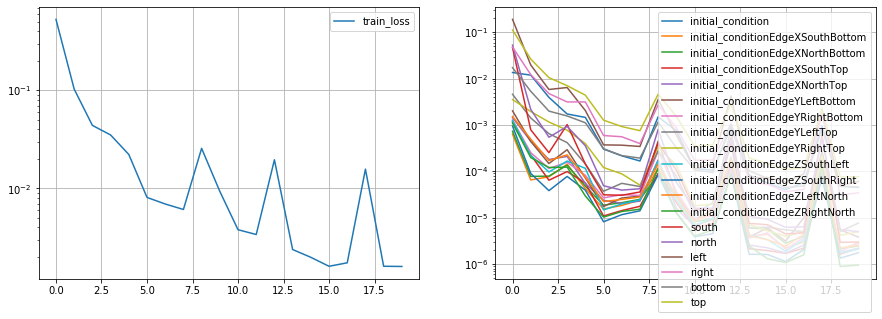

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(hist['train_loss'], label="train_loss")
ax1.grid(True)
ax1.legend()
ax1.set_yscale("log")
for boco in pde.bocos:
    ax2.plot(hist['bocos'][boco.name], label=boco.name)
ax2.legend()
ax2.grid(True)
ax2.set_yscale("log")
plt.show()

In [9]:

# evaluate the solution
x = np.linspace(0,1,10)
y = np.linspace(0,1,10)
z = np.linspace(0,1,10)
t = np.linspace(0,5,10)
p = []

pde.evaluate({'x': x, 'y': y, 'z': z, 't': np.array([-1])})
_p = pde.outputs['p']
p.append(_p)

ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(x, y, z, c=p, cmap=plt.get_cmap('Greys'))
plt.show()




ValueError: Unknown projection '3d'